In [2]:
# %pip install pydeseq2

# Differential Expression Pipeline

[Pydeseq2 Docs](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#id5)

In [3]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data


FILTER_COUNTS = False #whether to use count filtering

SAVE = True  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "../data/interim/PyDeseq2/"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

## Load Extracted Data

In [4]:
def get_counts():

    # Load raw data
    tbidata=pd.read_csv('../data/raw/tbi_data_files.csv')
    df_gene_counts=pd.read_csv('../data/interim/df_gene_counts.csv')
    genes=pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv')

    # Merge adnd map data
    merge_table=df_gene_counts.merge(tbidata,left_on='link',right_on='gene_level_fpkm_file_link')
    mapping_dict_gene=dict(zip(genes['gene_entrez_id'],genes['gene_id']))

    # Get total counts
    total_counts=merge_table[['expected_count','TPM','FPKM','donor_id', 'donor_name',
        'specimen_id', 'specimen_name','structure_id', 'structure_acronym', 'structure_name',
        'rnaseq_profile_id','gene_id']]
    total_counts['gene_id_mapped']=total_counts['gene_id'].map(mapping_dict_gene)
    unmapped_genes=list(total_counts[total_counts['gene_id_mapped'].isna()]['gene_id'].unique())
    total_counts=total_counts.drop(total_counts[total_counts['gene_id'].isin(unmapped_genes)].index)
    total_counts['expected_count']=np.round(total_counts['expected_count']).astype(int)
    total_counts['gene_id_mapped']=total_counts['gene_id_mapped'].astype(int)

    # Generate counts table
    ct_matrix=total_counts[['gene_id_mapped','rnaseq_profile_id','expected_count']].pivot(index='gene_id_mapped',columns='rnaseq_profile_id', values='expected_count')

    return ct_matrix

# Save load as .pkl file to maintain exact states
if os.path.exists('../data/interim/PyDeseq2/ct_matrix.pkl'):
    counts = pd.read_pickle('../data/interim/PyDeseq2/ct_matrix.pkl')
else:
    counts = get_counts()

    if SAVE:
        counts.to_pickle("../data/interim/PyDeseq2/ct_matrix.pkl")

/var/folders/_4/60jk4mm92bl_xrc0n8z2y4140000gn/T/ipykernel_26438/3140428334.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_counts['gene_id_mapped']=total_counts['gene_id'].map(mapping_dict_gene)


In [5]:
counts

rnaseq_profile_id,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,496100661,496100663,496100664,496100665,496100666,496100667,496100669,496100670,496100671,496100672
gene_id_mapped,,,,,,,,,,,,,,,,,,,,,
499304660,12,1,0,0,0,0,0,3,4,0,...,10,11,0,13,8,0,0,4,0,0
499304661,71,194,90,81,83,104,104,79,75,136,...,135,101,109,105,109,145,201,141,106,115
499304662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499304663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499304664,0,0,0,3,0,0,2,2,0,2,...,0,1,0,1,2,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499355059,337,188,242,364,368,420,329,288,265,511,...,432,349,307,639,482,481,343,388,467,329
499355060,0,0,1,0,2,2,0,3,0,4,...,1,0,0,2,2,0,0,1,5,1
499355061,5658,5006,4105,4788,4350,5922,3818,3807,5200,10299,...,6792,7016,6054,14007,8931,7448,6343,6841,7499,6235


In [6]:
# sns.displot(counts.loc[:,499355059])

In [7]:
# FPKM counts - Unnormalized counts are REQUIRED for this worflow.
# Genes are rows, samples are columns
# counts = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/fpkm_table_unnormalized.csv')
# counts = counts.set_index("gene_id \ rnaseq_profile_id")
# counts

In [8]:
# Drop all zero rows
counts = counts[counts.sum(axis=1) > 0]


if FILTER_COUNTS:

    #Filter low counts LOW COUNT THRESHOLD
    genes_to_keep = counts.columns[counts.sum(axis=0) >= 10]
    counts = counts[genes_to_keep]

In [9]:
# Set genes as columns, samples as rows / #rename column to reflect that...
counts = counts.T
counts

gene_id_mapped,499304660,499304661,499304664,499304665,499304666,499304667,499304668,499304669,499304670,499304671,...,499355054,499355055,499355056,499355057,499355058,499355059,499355060,499355061,499355062,499355063
rnaseq_profile_id,,,,,,,,,,,,,,,,,,,,,
488395315,12,71,0,0,0,0,0,11,6,109,...,6418,0,0,0,4118,337,0,5658,0,0
496100277,1,194,0,0,0,0,0,14,0,99,...,7137,0,0,0,3858,188,0,5006,0,1
496100278,0,90,0,0,0,0,0,21,3,120,...,8122,0,0,0,4189,242,1,4105,0,1
496100279,0,81,3,0,0,0,0,23,13,99,...,6536,0,0,0,4006,364,0,4788,0,2
496100281,0,83,0,0,0,0,0,20,0,131,...,6573,0,0,0,3507,368,2,4350,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496100667,0,145,2,0,0,1,0,22,9,79,...,11737,0,0,0,6605,481,0,7448,0,0
496100669,0,201,2,0,2,0,0,25,0,66,...,10176,1,0,0,6054,343,0,6343,0,1
496100670,4,141,0,0,0,0,0,11,14,130,...,7159,0,0,0,4473,388,1,6841,0,0


In [10]:
#Prepare metadata
sample_data = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/columns-samples.csv')
sample_data

,rnaseq_profile_id,donor_id,donor_name,specimen_id,specimen_name,rna_well_id,polygon_id,structure_id,structure_acronym,structure_color,structure_name,hemisphere
0,488395315,309335467,H14.09.030,309357843,H14.09.030.TCx.01,395325172,320817998,10235,TCx,#ebbfd0,temporal neocortex,left
1,496100277,309335441,H14.09.004,309357624,H14.09.004.PCx.01,320630866,310967169,10557,FWM,#f2f1f0,white matter of forebrain,right
2,496100278,309335438,H14.09.001,309357596,H14.09.001.PCx.01,320630834,310790571,10557,FWM,#f2f1f0,white matter of forebrain,left
3,496100279,309335438,H14.09.001,309357599,H14.09.001.TCx.01,320630838,310790522,10235,TCx,#ebbfd0,temporal neocortex,left
4,496100281,309335439,H14.09.002,309357603,H14.09.002.HIP.01,320630842,310790372,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right
...,...,...,...,...,...,...,...,...,...,...,...,...
372,496100667,467056391,H15.09.103,467179071,H15.09.103.TCx.01,482655826,480366830,10235,TCx,#ebbfd0,temporal neocortex,right
373,496100669,467056391,H15.09.103,467179068,H15.09.103.PCx.01,482655822,480363830,10557,FWM,#f2f1f0,white matter of forebrain,right
374,496100670,467056406,H15.09.107,467179104,H15.09.107.TCx.01,482655780,480363840,10235,TCx,#ebbfd0,temporal neocortex,right
375,496100671,467056391,H15.09.103,467179065,H15.09.103.HIP.01,482655820,480366825,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right


In [11]:
# Load donor info
donor_info = pd.read_csv('../data/raw/DonorInformation.csv')
donor_info

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1
1,326765656,H14.09.069,95-99,M,N,17,12,1-2 min,2,1,No Dementia,26,No Dementia,Y,White,Not Hispanic,No Dementia,5,2
2,326765654,H14.09.067,85,M,Y,10,72,< 10 sec,3,1,Vascular,25,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,4,2
3,467056391,H15.09.103,90-94,F,N,11,87,< 10 sec,0,1,No Dementia,52,No Dementia,Y,White,Not Hispanic,No Dementia,4,0
4,309335447,H14.09.010,100+,M,Y,16,0,Unknown or N/A,3,0,Alzheimer's Disease Type,28,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,309335458,H14.09.021,88,M,N,12,18,> 1 hr,0,1,Alzheimer's Disease Type,21,Probable Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,1,1
103,309335462,H14.09.025,84,M,N,16,23,10 min - 1 hr,0,2,Alzheimer's Disease Type,40,Probable Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,0,0
104,309335454,H14.09.017,79,M,N,16,13,< 10 sec,2,3,No Dementia,44,No Dementia,Y,White,Not Hispanic,No Dementia,3,2
105,309335486,H14.09.049,95-99,M,N,21,18,3-5 min,1,1,No Dementia,12,No Dementia,Y,White,Not Hispanic,No Dementia,3,1


In [12]:
donor_info['act_demented'].value_counts()

No Dementia    57
Dementia       50
Name: act_demented, dtype: int64

In [13]:
# Process donor info to segregate control group
control_group_df = donor_info[donor_info['act_demented'] == 'No Dementia']
dementia_group_df = donor_info[donor_info['act_demented'] != 'No Dementia']

# Get donor ids
control_ids = control_group_df['donor_id']
dementia_ids = dementia_group_df['donor_id']

# Assign condition to sample data
sample_data['Condition'] = sample_data['donor_id'].apply(lambda x: 'control' if x in control_ids.values else 'dementia')
sample_data

,rnaseq_profile_id,donor_id,donor_name,specimen_id,specimen_name,rna_well_id,polygon_id,structure_id,structure_acronym,structure_color,structure_name,hemisphere,Condition
0,488395315,309335467,H14.09.030,309357843,H14.09.030.TCx.01,395325172,320817998,10235,TCx,#ebbfd0,temporal neocortex,left,control
1,496100277,309335441,H14.09.004,309357624,H14.09.004.PCx.01,320630866,310967169,10557,FWM,#f2f1f0,white matter of forebrain,right,control
2,496100278,309335438,H14.09.001,309357596,H14.09.001.PCx.01,320630834,310790571,10557,FWM,#f2f1f0,white matter of forebrain,left,control
3,496100279,309335438,H14.09.001,309357599,H14.09.001.TCx.01,320630838,310790522,10235,TCx,#ebbfd0,temporal neocortex,left,control
4,496100281,309335439,H14.09.002,309357603,H14.09.002.HIP.01,320630842,310790372,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right,dementia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,496100667,467056391,H15.09.103,467179071,H15.09.103.TCx.01,482655826,480366830,10235,TCx,#ebbfd0,temporal neocortex,right,control
373,496100669,467056391,H15.09.103,467179068,H15.09.103.PCx.01,482655822,480363830,10557,FWM,#f2f1f0,white matter of forebrain,right,control
374,496100670,467056406,H15.09.107,467179104,H15.09.107.TCx.01,482655780,480363840,10235,TCx,#ebbfd0,temporal neocortex,right,dementia
375,496100671,467056391,H15.09.103,467179065,H15.09.103.HIP.01,482655820,480366825,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right,control


In [14]:
# metadata = sample_data[['structure_acronym', 'hemisphere']].set_index(counts.index)
metadata = sample_data[['rnaseq_profile_id', 'Condition']].set_index('rnaseq_profile_id')
metadata.value_counts()

Condition
control      197
dementia     180
dtype: int64

In [15]:
metadata

,Condition
rnaseq_profile_id,
488395315,control
496100277,control
496100278,control
496100279,control
496100281,dementia
...,...
496100667,control
496100669,control
496100670,dementia


# Single factor Analysis

In [16]:
# Set up Deseq object
try:
    dds = DeseqDataSet(counts=counts,
             metadata = metadata,
             design_factors = ['Condition'])
except ValueError as err:
    print(err)

# try:
#     dds = DeseqDataSet(counts=counts,
#              metadata = metadata,
#              design_factors = ['Condition'],
#              ref_level= ['Condition', 'control'])
# except ValueError as err:
#     print(err)

/opt/homebrew/Caskroom/miniforge/base/envs/pydseq2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
# Run deseq2
dds.deseq2()

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "wb") as f:
        pkl.dump(dds, f)

Fitting size factors...
... done in 0.27 seconds.

Fitting dispersions...
... done in 5.57 seconds.

Fitting dispersion trend curve...
... done in 5.49 seconds.

Fitting MAP dispersions...
... done in 7.71 seconds.

Fitting LFCs...
... done in 4.45 seconds.

Refitting 248 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.06 seconds.



In [18]:
# Statistics have been added to dds object
dds

AnnData object with n_obs × n_vars = 377 × 46726
    obs: 'Condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

- X stores the count data,
- obs stores design factors,
- obsm stores sample-level data, such as "design_matrix" and "size_factors",
- varm stores gene-level data, such as "dispersions" and "LFC".


In [19]:
# What is LFC? - effect size
dds.varm["LFC"]

,intercept,Condition_dementia_vs_control
gene_id_mapped,,
499304660,1.171024,0.217353
499304661,4.768193,0.078463
499304664,-0.384622,0.267508
499304665,-1.687327,0.021261
499304666,-1.636568,0.326058
...,...,...
499355059,5.726860,0.175822
499355060,-0.331140,0.329539
499355061,8.712413,0.222488


## Statistical analysis with the DeseqStats class

- baseMean:
    - The baseMean is the average of the normalized count values for a gene across all samples in the experiment. It represents the average expression level of a gene, taking into account the inherent variability in the data.

- log2FoldChange:
    - The log2FoldChange is a measure of the fold change in gene expression between two groups or conditions. It's calculated as the logarithm (base 2) of the ratio of expression levels in the two compared groups. A positive log2FoldChange indicates upregulation in one group compared to the other, while a negative value suggests downregulation.

- lfcSE (log2FoldChange standard error):
    - The lfcSE represents the standard error associated with the log2FoldChange. It provides information about the uncertainty or variability in the estimated fold change. Smaller lfcSE values indicate more confidence in the log2FoldChange estimate.

- stat:
    - The 'stat' value, also known as the Wald statistic, is calculated by dividing the log2FoldChange by its standard error (lfcSE). It is used to assess the significance of the fold change and is often used in hypothesis testing to determine if the change in expression is statistically significant.

- pvalue:
   - The p-value is a statistical measure that assesses the likelihood of observing the log2FoldChange under the null hypothesis, which typically assumes no differential expression. A lower p-value indicates stronger evidence against the null hypothesis and suggests that the observed differential expression is statistically significant.

- padj (adjusted p-value):
    - The padj is the p-value after adjusting for multiple testing, often using methods like the Benjamini-Hochberg procedure. It helps control the false discovery rate (FDR), which is the expected proportion of falsely identified significant genes. A smaller padj suggests a more reliable identification of differentially expressed genes.

In [20]:
# Dementia and control group and need to be defined before this is done...need to compare groups
# stat_res = DeseqStats(dds, contrast = ('Condition', 'dementia', 'control'))
stat_res = DeseqStats(dds)

In [21]:
stat_res.summary()

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "stat_results.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

Running Wald tests...
... done in 2.08 seconds.



Log2 fold change & Wald test p-value: Condition dementia vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id_mapped,,,,,,
499304660,3.585072,0.313573,0.235800,1.329830,0.183574,0.303530
499304661,122.147229,0.113198,0.049590,2.282652,0.022451,0.055735
499304664,0.783430,0.385932,0.196190,1.967132,0.049168,0.106013
499304665,0.011929,0.030673,2.909236,0.010543,0.991588,NaN
499304666,0.105425,0.470402,1.181253,0.398222,0.690466,NaN
...,...,...,...,...,...,...
499355059,335.231725,0.253657,0.081155,3.125595,0.001774,0.006526
499355060,0.871897,0.475424,0.224797,2.114898,0.034439,0.079293
499355061,6801.034277,0.320983,0.086041,3.730562,0.000191,0.000947


In [22]:
#Get dataframe from stat_res
res = stat_res.results_df
res.index.name = 'gene_id'
res.index = res.index.astype(str)
res



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
499304660,3.585072,0.313573,0.235800,1.329830,0.183574,0.303530
499304661,122.147229,0.113198,0.049590,2.282652,0.022451,0.055735
499304664,0.783430,0.385932,0.196190,1.967132,0.049168,0.106013
499304665,0.011929,0.030673,2.909236,0.010543,0.991588,NaN
499304666,0.105425,0.470402,1.181253,0.398222,0.690466,NaN
...,...,...,...,...,...,...
499355059,335.231725,0.253657,0.081155,3.125595,0.001774,0.006526
499355060,0.871897,0.475424,0.224797,2.114898,0.034439,0.079293
499355061,6801.034277,0.320983,0.086041,3.730562,0.000191,0.000947


Add gene symbols from gene_id (rows_gene.csv)

In [23]:
gene_data = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv')
gene_data

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499304660,1,100287102,DDX11L1,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...
1,499304661,1,653635,WASH7P,WAS protein family homolog 7 pseudogene
2,499304662,1,102466751,MIR6859-1,microRNA 6859-1
3,499304663,1,100302278,MIR1302-2,microRNA 1302-2
4,499304664,1,645520,FAM138A,"family with sequence similarity 138, member A"
...,...,...,...,...,...
50276,499355059,MT,4541,ND6,NADH dehydrogenase subunit 6
50277,499355060,MT,4556,TRNE,tRNA-Glu
50278,499355061,MT,4519,CYTB,cytochrome b
50279,499355062,MT,4576,TRNT,tRNA-Thr


In [24]:
res.index = res.index.astype(int)
res = res.merge(gene_data[['gene_id', 'gene_symbol', 'gene_name']], on= 'gene_id', how = 'left').set_index('gene_id')

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "stats_results_df_with_gene_names.pkl"), "wb") as f:
        pkl.dump(res, f)


In [25]:
res.sort_values(by='stat', ascending= False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,gene_name
gene_id,,,,,,,,
499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,SLC6A12,solute carrier family 6 (neurotransmitter tran...
499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,COL27A1,"collagen, type XXVII, alpha 1"
499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,BCAM,basal cell adhesion molecule (Lutheran blood g...
499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,DOK7,docking protein 7
499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,BCL9L,B-cell CLL/lymphoma 9-like
...,...,...,...,...,...,...,...,...
499332345,1494.238722,-0.246278,0.027909,-8.824339,1.101078e-18,5.059592e-15,C11orf58,chromosome 11 open reading frame 58
499336370,316.017874,-0.398039,0.044790,-8.886793,6.289808e-19,3.853660e-15,ACTR6,ARP6 actin-related protein 6 homolog (yeast)
499326558,1897.126165,-0.277358,0.031127,-8.910527,5.079069e-19,3.734233e-15,IMPAD1,inositol monophosphatase domain containing 1


In [26]:
# Filter out low baseMean genes
# res = res[res.baseMean >= 10]
# res

In [27]:
#  View count of sig values only
len(res[res.padj < 0.05])

14487

In [28]:
# res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1)]

In [29]:
# filter by sig values and log2FoldChanfge; Moura et all showed 602 DE genes out of 50,281)
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]

sigs = sigs.sort_values(by='stat', ascending= False)
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,gene_name
gene_id,,,,,,,,
499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,SLC6A12,solute carrier family 6 (neurotransmitter tran...
499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,COL27A1,"collagen, type XXVII, alpha 1"
499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,BCAM,basal cell adhesion molecule (Lutheran blood g...
499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,DOK7,docking protein 7
499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,BCL9L,B-cell CLL/lymphoma 9-like
...,...,...,...,...,...,...,...,...
499317260,5.094264,-0.663785,0.096101,-6.907176,4.943969e-12,2.957633e-10,CETN4P,"centrin EF-hand protein 4, pseudogene"
499315537,36.434647,-0.810436,0.115235,-7.032873,2.023236e-12,1.433067e-10,SST,somatostatin
499336206,15.894155,-0.749150,0.105873,-7.075939,1.484397e-12,1.122797e-10,LOC728084,uncharacterized LOC728084


In [30]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "sig_stats_results_df_with_gene_names.pkl"), "wb") as f:
        pkl.dump(sigs, f)

~ 1017 significant genes with a logfold change greater than 0.5.

## Grab top and bottom 10 genes for use in ML models

In [31]:
top_bottom_ten_sigs = pd.concat((sigs.head(10),sigs.tail(10))).reset_index().copy()
top_bottom_ten_sigs

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,gene_name
0,499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,SLC6A12,solute carrier family 6 (neurotransmitter tran...
1,499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,COL27A1,"collagen, type XXVII, alpha 1"
2,499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,BCAM,basal cell adhesion molecule (Lutheran blood g...
3,499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,DOK7,docking protein 7
4,499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,BCL9L,B-cell CLL/lymphoma 9-like
5,499336992,416.437010,0.503428,0.059266,8.494376,1.989994e-17,3.516265e-14,POLE,"polymerase (DNA directed), epsilon, catalytic ..."
6,499343767,8.958929,0.932315,0.110690,8.422767,3.676938e-17,5.631997e-14,LOC101927793,uncharacterized LOC101927793
7,499350441,64.157794,0.576297,0.069073,8.343360,7.220912e-17,7.584227e-14,FAM65C,"family with sequence similarity 65, member C"
8,499347240,21.094762,1.060460,0.128233,8.269796,1.341886e-16,1.121115e-13,LOC105372247,uncharacterized LOC105372247
9,499343769,19.159753,1.194486,0.144620,8.259452,1.463424e-16,1.170342e-13,LOC105371409,uncharacterized LOC105371409


In [32]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "top_bottom_ten_sigs.pkl"), "wb") as f:
        pkl.dump(top_bottom_ten_sigs, f)

## PCA

In [33]:
# !pip install scanpy

In [34]:
import scanpy as sc

In [35]:
sc.tl.pca(dds)

/opt/homebrew/Caskroom/miniforge/base/envs/pydseq2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


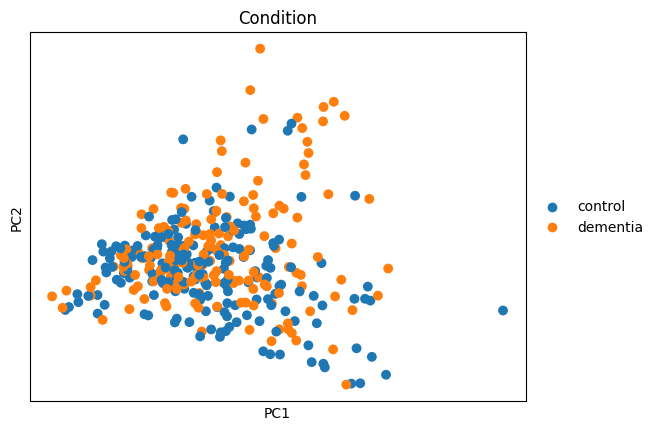

In [36]:
sc.pl.pca(dds, color = 'Condition', size = 200)

No clear difference between demntia and control

## GSEA (Gene Set Enrichment Analysis)

The next logical step now will be to query the function of these DEGs. Summarize DE results.

"The statistically significant Differentially Expressed Genes (DEGs) with the smallest P-values obtained by using LMM were used with gene ontology enrichment analysis to identify the enriched dysfunctional biological implications associated with these genes"

"Gene set enrichment analysis was performed to find the significantly enriched co-regulated gene sets or pathways."

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7717689/

In [37]:
sigs.index = sigs.index.astype(int)
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,gene_name
gene_id,,,,,,,,
499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,SLC6A12,solute carrier family 6 (neurotransmitter tran...
499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,COL27A1,"collagen, type XXVII, alpha 1"
499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,BCAM,basal cell adhesion molecule (Lutheran blood g...
499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,DOK7,docking protein 7
499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,BCL9L,B-cell CLL/lymphoma 9-like
...,...,...,...,...,...,...,...,...
499317260,5.094264,-0.663785,0.096101,-6.907176,4.943969e-12,2.957633e-10,CETN4P,"centrin EF-hand protein 4, pseudogene"
499315537,36.434647,-0.810436,0.115235,-7.032873,2.023236e-12,1.433067e-10,SST,somatostatin
499336206,15.894155,-0.749150,0.105873,-7.075939,1.484397e-12,1.122797e-10,LOC728084,uncharacterized LOC728084


In [38]:
# !pip install gseapy

In [39]:
import gseapy as gp
from gseapy.plot import gseaplot


# Get ranked list of genes (input)

In [40]:
ranking = sigs[['gene_symbol', 'stat']].dropna().sort_values('stat', ascending = False)
ranking



,gene_symbol,stat
gene_id,,
499334626,SLC6A12,9.225475
499329195,COL27A1,9.049389
499348654,BCAM,8.845883
499315843,DOK7,8.761582
499334295,BCL9L,8.554856
...,...,...
499317260,CETN4P,-6.907176
499315537,SST,-7.032873
499336206,LOC728084,-7.075939


In [41]:
ranking.drop_duplicates('gene_symbol')
ranking

,gene_symbol,stat
gene_id,,
499334626,SLC6A12,9.225475
499329195,COL27A1,9.049389
499348654,BCAM,8.845883
499315843,DOK7,8.761582
499334295,BCL9L,8.554856
...,...,...
499317260,CETN4P,-6.907176
499315537,SST,-7.032873
499336206,LOC728084,-7.075939


In [42]:
# Gene set
manual_set = {'symbols': ranking['gene_symbol'].values}

### GESEA Tutorial
https://medium.com/omics-diary/how-to-use-gseapy-for-pathway-enrichment-analysis-67a1aab1002d

In [43]:
# DEGs = ranking['gene_symbol'].tolist()

In [44]:
# gp.enrichr?

In [45]:
# enr_GOBP_up = gp.enrichr(gene_list=DEGs ,
#  gene_sets=['GO_Biological_Process_2021', 'GO_Molecular_Function_2021', 'GO_Cellular_Component_2021', 'Reactome_2016'],
#  organism='Human', 
#  outdir=OUTPUT_PATH,
#  cutoff=0.05 
#  )

In [46]:
# enr_GOBP_up.results

In [47]:
# from gseapy.plot import barplot, dotplot

# barplot(enr_GOBP_up.res2d,title='GO Biological Processes',color = 'r')

### Following Pydesq tutorial

In [48]:
pre_res = gp.prerank(rnk=ranking, gene_sets = ['GO_Biological_Process_2021', manual_set],
                     seed = 6, permutation_num = 100)

2023-11-21 12:17:59,166 [WARNING] Duplicated values found in preranked stats: 0.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [49]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df

,Term,fdr,es,nes
0,GO_Biological_Process_2021__anterograde trans-...,0.000000,-0.581364,-2.415221
1,GO_Biological_Process_2021__chemical synaptic ...,0.000000,-0.625294,-2.711916
2,GO_Biological_Process_2021__positive regulatio...,0.010980,0.473294,2.094109
3,GO_Biological_Process_2021__positive regulatio...,0.014640,0.416336,1.930487
4,GO_Biological_Process_2021__negative regulatio...,0.021959,0.577655,2.119351
5,GO_Biological_Process_2021__regulation of tran...,0.030194,0.376092,1.825450
6,GO_Biological_Process_2021__positive regulatio...,0.087838,0.442356,1.613442
7,GO_Biological_Process_2021__positive regulatio...,0.100190,0.385162,1.490920
8,GO_Biological_Process_2021__positive regulatio...,0.106660,0.393281,1.508022
9,GO_Biological_Process_2021__regulation of tran...,0.115287,0.325451,1.529824


In [50]:
# out_df.sort_values('nes').iloc[0].Term

In [51]:
prr = pre_res.results['GO_Biological_Process_2021__regulation of transcription, DNA-templated (GO:0006355)']
# prr

In [52]:
# Not getting gseaplot as expected...why?

# gseaplot(pre_res.ranking.values, hits = prr['hits'], nes = prr['nes'], pval = prr['pval'], fdr = prr['fdr'], RES = prr['RES'])

# gseaplot(pre_res.ranking,
#          term = 'GO_Biological_Process_2021__regulation of transcription, DNA-templated (GO:0006355)',
#          **pre_res.results['GO_Biological_Process_2021__regulation of transcription, DNA-templated (GO:0006355)'])

In [53]:
# dds.layers['normed_counts']

## Clustermap

In [54]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

In [55]:
# dds.layers['log1p']

In [56]:
# Comment out if no good
top_sigs = pd.concat((sigs.head(10),sigs.tail(10))).copy()

In [57]:
# sigs.index = sigs.index.astype(str)
top_sigs.index = top_sigs.index.astype(str)

In [58]:
# sigs.index

In [59]:
# dds

In [60]:
dds_sigs = dds[:, top_sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 377 × 20
    obs: 'Condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var', 'pca', 'Condition_colors'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'PCs'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks', 'log1p'

In [61]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)



In [62]:
import seaborn as sns

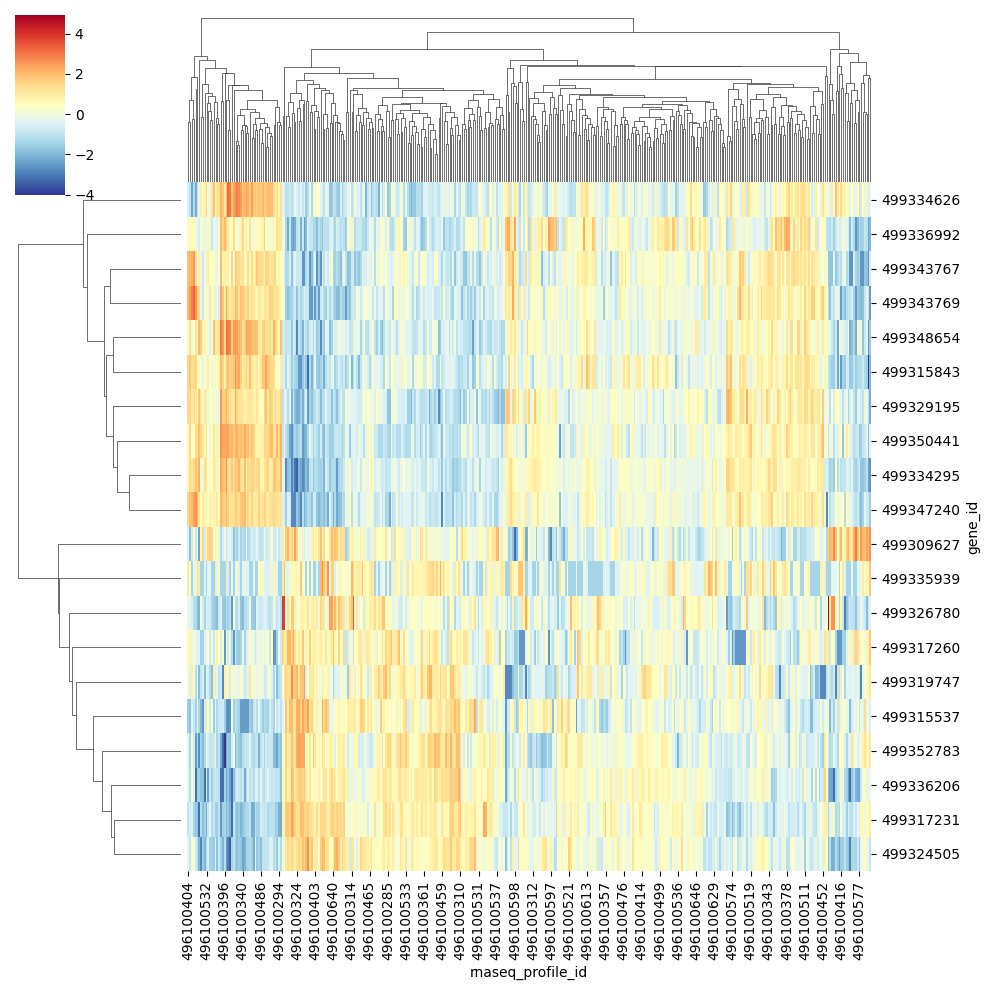

In [63]:
sns.clustermap(grapher, z_score=0, cmap = 'RdYlBu_r')

## Volcano Plot


In [64]:
from sanbomics.plots import volcano

res


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,gene_name
gene_id,,,,,,,,
499304660,3.585072,0.313573,0.235800,1.329830,0.183574,0.303530,DDX11L1,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...
499304661,122.147229,0.113198,0.049590,2.282652,0.022451,0.055735,WASH7P,WAS protein family homolog 7 pseudogene
499304664,0.783430,0.385932,0.196190,1.967132,0.049168,0.106013,FAM138A,"family with sequence similarity 138, member A"
499304665,0.011929,0.030673,2.909236,0.010543,0.991588,NaN,LOC105379212,uncharacterized LOC105379212
499304666,0.105425,0.470402,1.181253,0.398222,0.690466,NaN,OR4G4P,"olfactory receptor, family 4, subfamily G, mem..."
...,...,...,...,...,...,...,...,...
499355059,335.231725,0.253657,0.081155,3.125595,0.001774,0.006526,ND6,NADH dehydrogenase subunit 6
499355060,0.871897,0.475424,0.224797,2.114898,0.034439,0.079293,TRNE,tRNA-Glu
499355061,6801.034277,0.320983,0.086041,3.730562,0.000191,0.000947,CYTB,cytochrome b


In [65]:
# volcano?

Volcano plot of the False Discovery Rate (FDR) corrected p-values vs log_2 fold change. Genes above the horizontal dashed line have p < 0.05 after FDR correction.

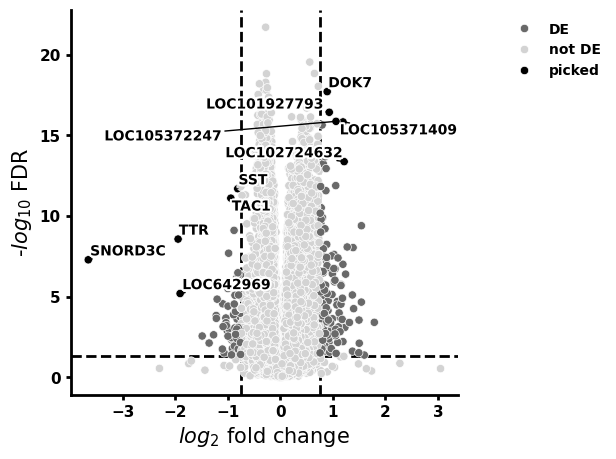

In [66]:
volcano(
    res,
    # log2fc="log2FoldChange",
    pvalue="pvalue",
    symbol="gene_symbol",
    # baseMean="baseMean",
    # pval_thresh=0.05,
    # log2fc_thresh=0.5,
)

In [67]:
# volcano(
#     res,
#     log2fc="log2FoldChange",
#     pvalue="pvalue",
#     symbol="gene_symbol",
#     baseMean="baseMean",
#     pval_thresh=0.05,
#     log2fc_thresh=0.5,
# )

## Optional: Threshold-based test

Running Wald tests...
... done in 3.30 seconds.



Log2 fold change & Wald test p-value: Condition dementia vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
499304660,3.585072,0.313573,0.235800,0.905741,0.365073,0.949820
499304661,122.147229,0.113198,0.049590,0.266134,0.790136,1.000000
499304664,0.783430,0.385932,0.196190,1.457422,0.145000,0.517260
499304665,0.011929,0.030673,2.909236,0.000000,1.000000,NaN
499304666,0.105425,0.470402,1.181253,0.313567,0.753850,NaN
...,...,...,...,...,...,...
499355059,335.231725,0.253657,0.081155,1.893384,0.058307,0.273201
499355060,0.871897,0.475424,0.224797,1.670053,0.094909,0.383644
499355061,6801.034277,0.320983,0.086041,2.568330,0.010219,0.075284


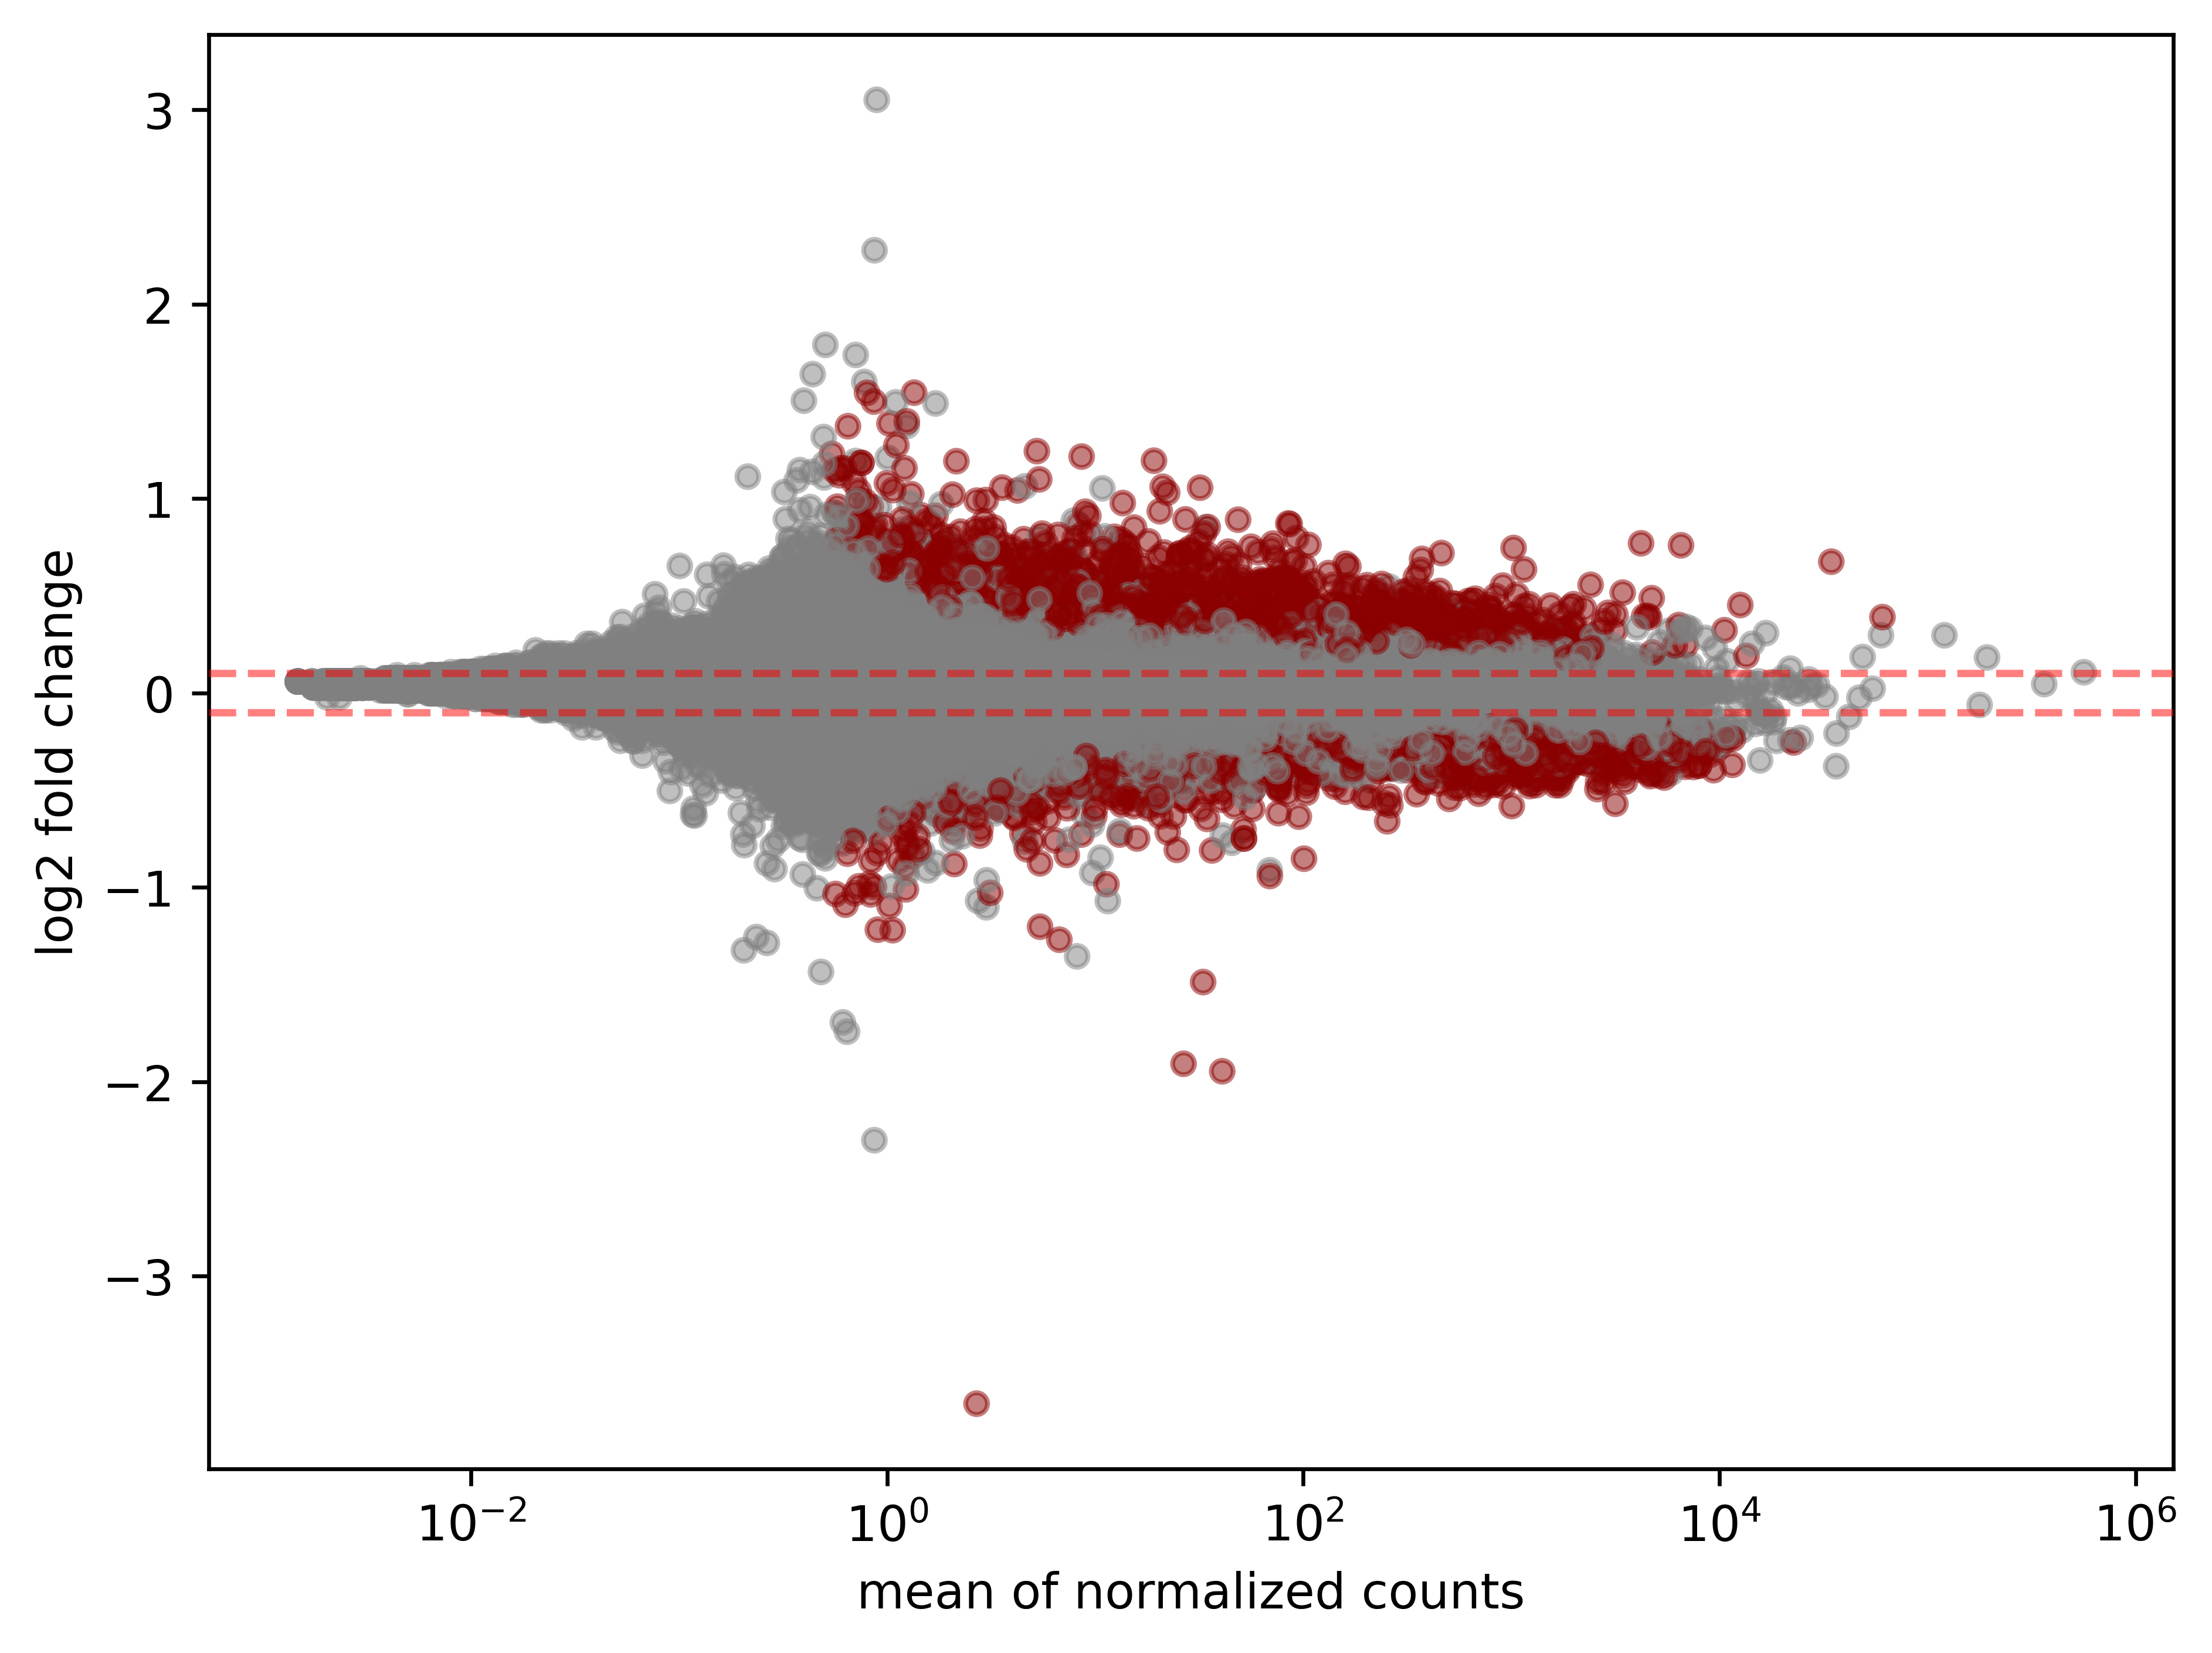

In [68]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
stat_res.plot_MA(s=20)

In [69]:
#LFC shrinkage
"""Shrinkage of effect size (LFC estimates) is useful for visualization and ranking of genes.
It is more useful visualize the MA-plot for the shrunken log2 fold changes,
which remove the noise associated with log2 fold changes from low count genes without requiring arbitrary filtering thresholds."""

stat_res.lfc_shrink(coeff="Condition_dementia_vs_control")

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "shrunk_stat_results.pkl"), "wb") as f:
        pkl.dump(stat_res, f)


Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Condition dementia vs control


... done in 6.87 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
499304660,3.585072,0.073178,0.162926,0.905741,0.365073,0.949820
499304661,122.147229,0.100394,0.048788,0.266134,0.790136,1.000000
499304664,0.783430,0.160413,0.192953,1.457422,0.145000,0.517260
499304665,0.011929,-0.000700,0.155701,0.000000,1.000000,NaN
499304666,0.105425,0.018641,0.249032,0.313567,0.753850,NaN
...,...,...,...,...,...,...
499355059,335.231725,0.219103,0.082035,1.893384,0.058307,0.273201
499355060,0.871897,0.167400,0.224832,1.670053,0.094909,0.383644
499355061,6801.034277,0.322982,0.088054,2.568330,0.010219,0.075284


Log2 fold change & Wald test p-value: Condition dementia vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
499304660,3.585072,0.073178,0.162926,0.905741,0.365073,0.949820
499304661,122.147229,0.100394,0.048788,0.266134,0.790136,1.000000
499304664,0.783430,0.160413,0.192953,1.457422,0.145000,0.517260
499304665,0.011929,-0.000700,0.155701,0.000000,1.000000,NaN
499304666,0.105425,0.018641,0.249032,0.313567,0.753850,NaN
...,...,...,...,...,...,...
499355059,335.231725,0.219103,0.082035,1.893384,0.058307,0.273201
499355060,0.871897,0.167400,0.224832,1.670053,0.094909,0.383644
499355061,6801.034277,0.322982,0.088054,2.568330,0.010219,0.075284


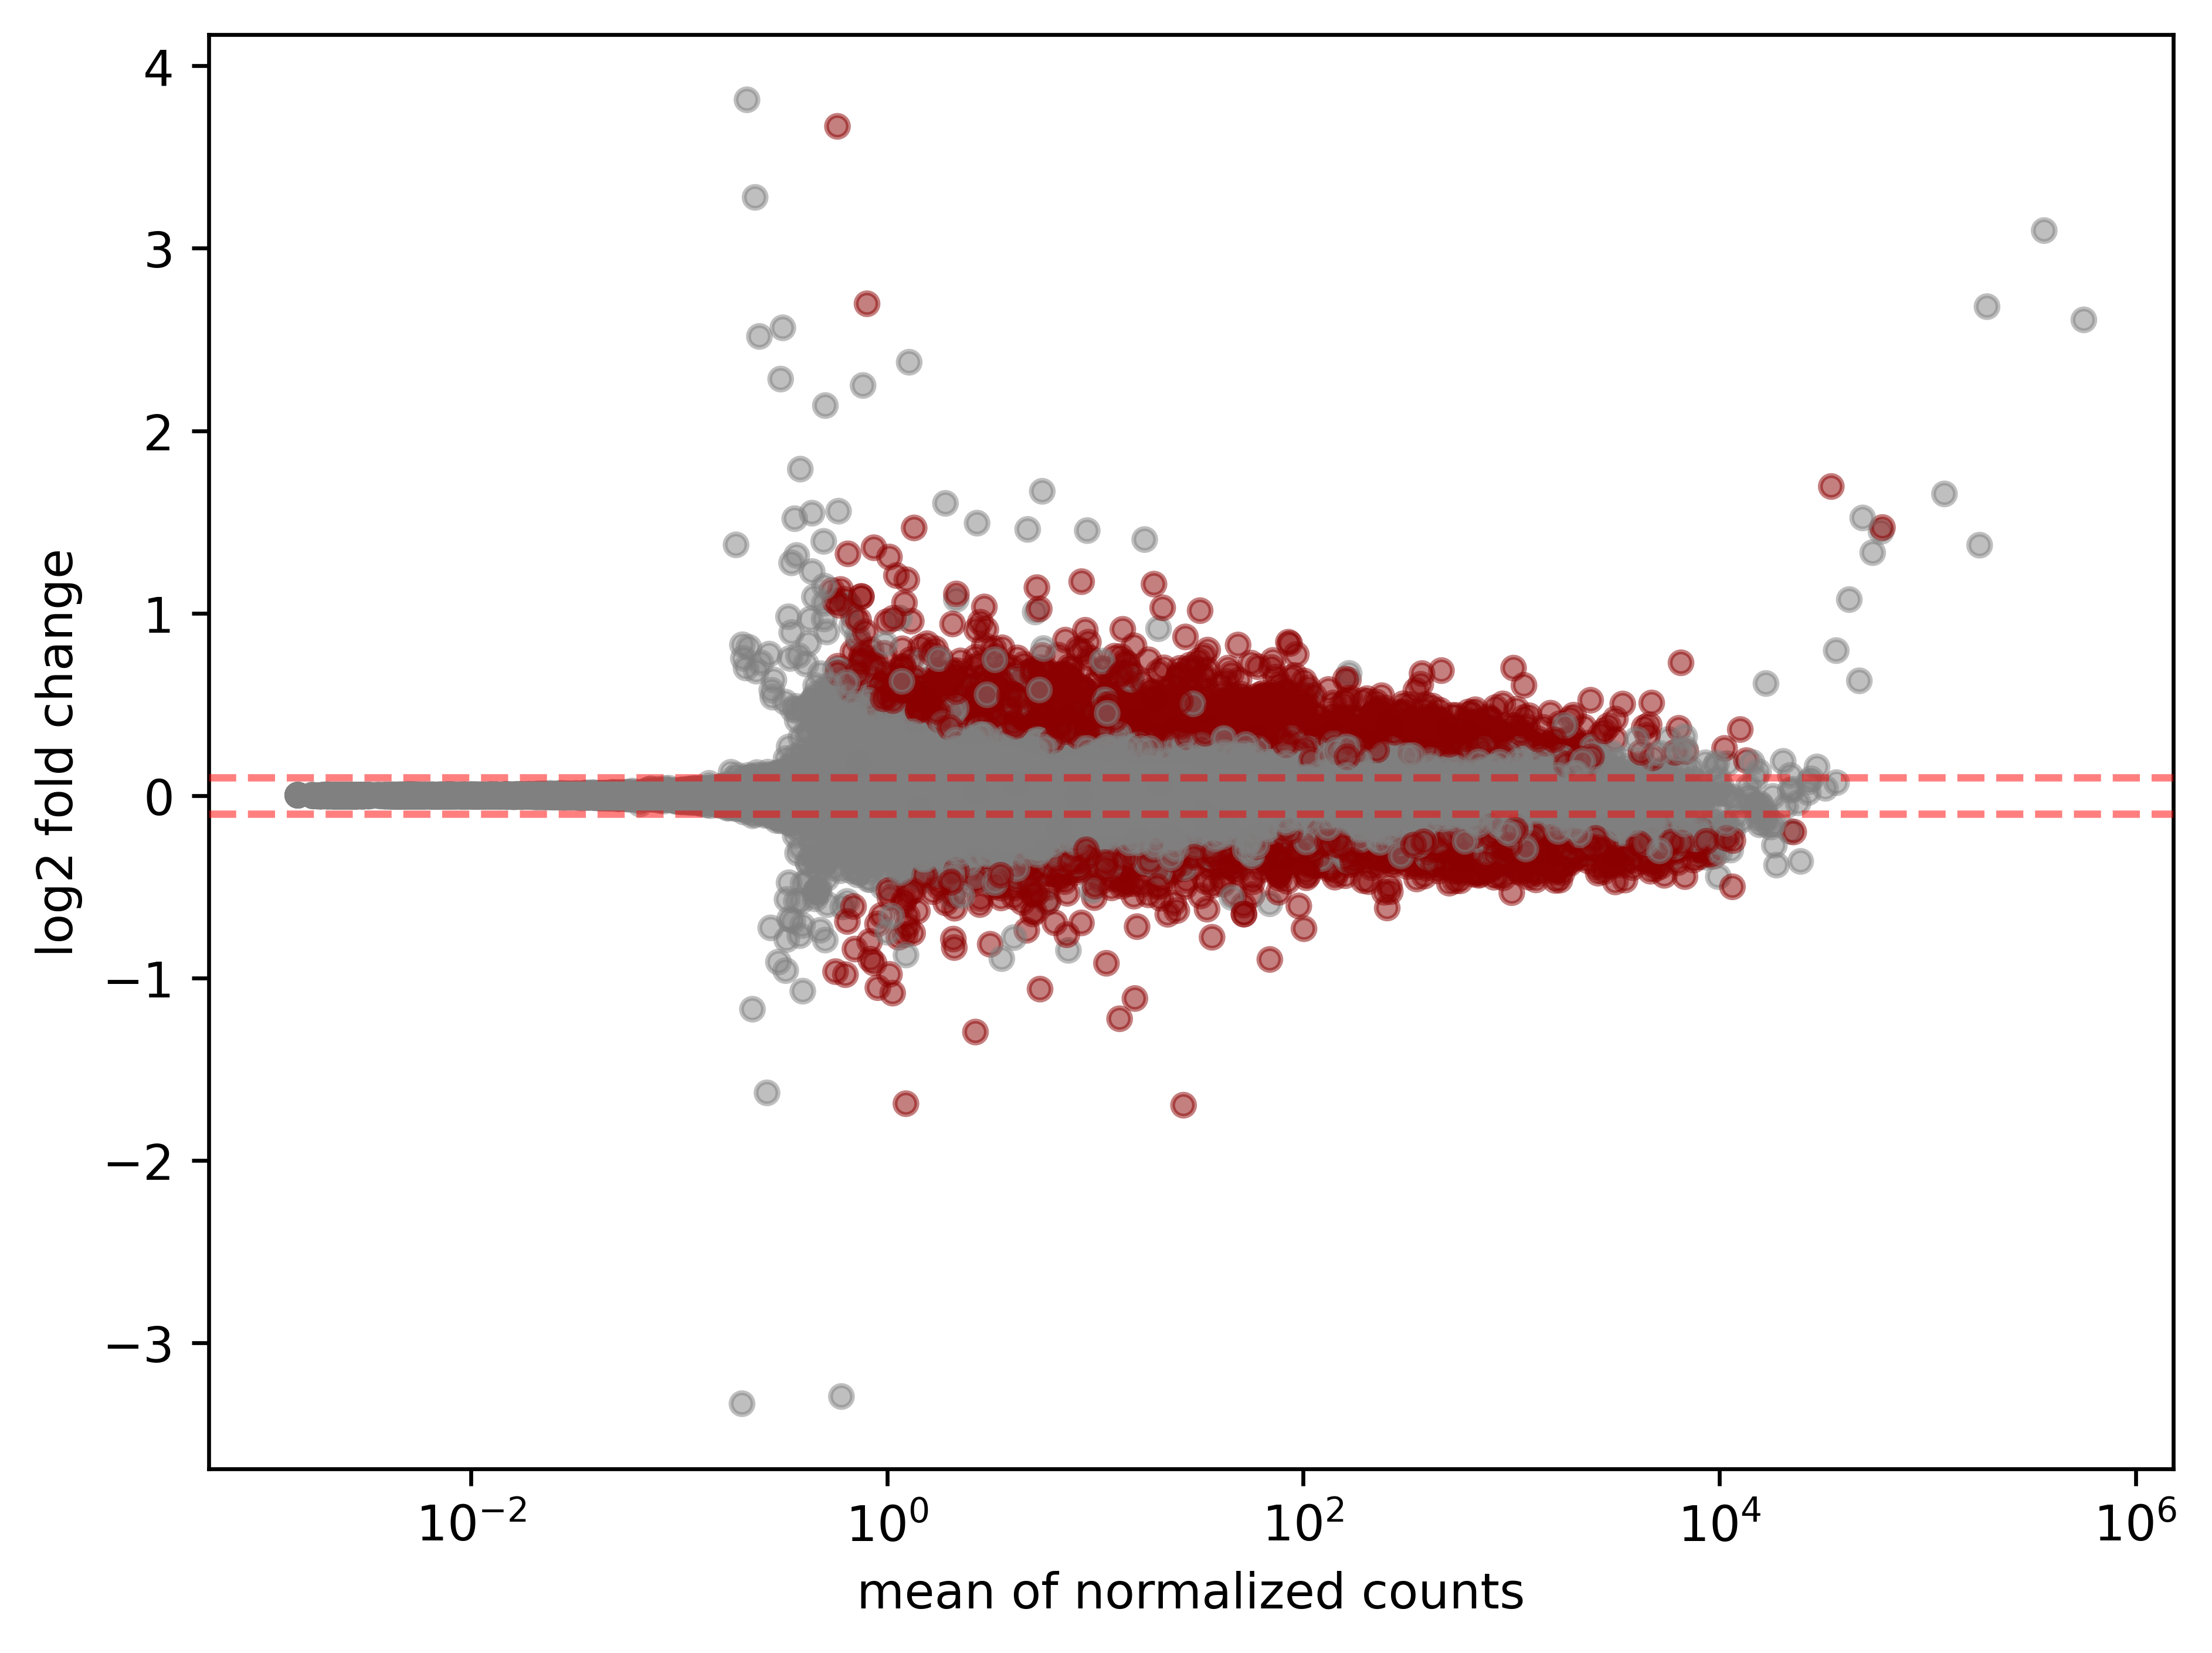

In [70]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
stat_res.plot_MA(s=20)

In [74]:
shrunk_sigs = stat_res.results_df.sort_values(by='stat', ascending= False)
shrunk_sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
499315843,27.153886,0.869584,0.102519,7.780014,7.251648e-15,2.534378e-10
499329195,164.742083,0.634118,0.072194,7.656743,1.907081e-14,2.649494e-10
499348654,60.631167,0.706080,0.082262,7.623367,2.471429e-14,2.649494e-10
499334626,238.077979,0.547456,0.061056,7.579418,3.471089e-14,2.649494e-10
499343769,19.159753,1.158788,0.145792,7.567987,3.790514e-14,2.649494e-10
...,...,...,...,...,...,...
499316280,1105.621802,-0.276894,0.028708,-6.254290,3.993281e-10,2.537476e-07
499317408,1341.419426,-0.427708,0.053702,-6.340581,2.289001e-10,1.680850e-07
499310118,663.390991,-0.416977,0.051354,-6.415422,1.404333e-10,1.305482e-07


In [75]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "shrunk_sigs.pkl"), "wb") as f:
        pkl.dump(shrunk_sigs, f)

In [76]:
top_bottom_ten_shrunk_sigs = pd.concat((shrunk_sigs.head(10),shrunk_sigs.tail(10))).reset_index().copy()
top_bottom_ten_shrunk_sigs

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,499315843,27.153886,0.869584,0.102519,7.780014,7.251648e-15,2.534378e-10
1,499329195,164.742083,0.634118,0.072194,7.656743,1.907081e-14,2.649494e-10
2,499348654,60.631167,0.706080,0.082262,7.623367,2.471429e-14,2.649494e-10
3,499334626,238.077979,0.547456,0.061056,7.579418,3.471089e-14,2.649494e-10
4,499343769,19.159753,1.158788,0.145792,7.567987,3.790514e-14,2.649494e-10
5,499343767,8.958929,0.906017,0.111562,7.519342,5.505249e-14,3.206716e-10
6,499347240,21.094762,1.029199,0.129223,7.489965,6.889215e-14,3.439588e-10
7,499304789,92.544266,0.773324,0.097691,7.176608,7.146195e-13,3.121904e-09
8,499340041,20.099347,0.676769,0.085156,7.047044,1.827589e-12,7.096933e-09
9,499343768,8.603769,1.172512,0.162591,6.932536,4.133613e-12,1.335127e-08


In [77]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "top_bottom_ten_shrunk_sigs.pkl"), "wb") as f:
        pkl.dump(top_bottom_ten_shrunk_sigs, f)

In [92]:
# Top genes that are in both sigs and sigs with LFC shrinkage.
np.intersect1d(top_bottom_ten_shrunk_sigs.gene_id.values, top_bottom_ten_sigs.gene_id.values.astype(str))

array(['499315537', '499315843', '499329195', '499334626', '499343767',
       '499343769', '499347240', '499348654'], dtype=object)

# Multifactor Analysis